In [33]:

from PIL import Image
import numpy as np
import glob
import regex 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier


In [34]:



def read_dataset(path):
  data= np.zeros([400,10305])
  i=0
  images_list = []
  for filename in glob.glob(path+"/*/*.pgm"): 
    im=Image.open(filename)
    images_list.append(im)
    l=regex.split(r'/', filename)
    l2= regex.split(r's', l[1])
    arr = np.array(im)
    data[i,0:10304]=arr.reshape(1,10304)
    data[i, -1]=l2[1]
    i+=1
  return data, images_list

    

In [35]:
def data_splitting(data):
    rows,cols=data.shape
    test_X = np.zeros([int(rows*0.5),cols-1])
    train_X = np.zeros([int(rows*0.5),cols-1])
    test_y= np.zeros(int(rows*0.5))
    train_y=np.zeros(int(rows*0.5))
    for i in range(data.shape[0]):
        if i%2 == 0:
            test_X[int(i/2)]=data[i,:-1]
            test_y[int(i/2)]= data[i,-1]
        else:
            train_X[int((i-1)/2)]=data[i,:-1]
            train_y[int((i-1)/2)]= data[i,-1] 
    return train_X, train_y, test_X, test_y


In [36]:
def data_splitting_70(data):
    rows,cols=data.shape
    test_X = np.zeros([int(rows*0.3),cols-1])
    train_X = np.zeros([int(rows*0.7),cols-1])
    test_y= np.zeros(int(rows*0.3))
    train_y=np.zeros(int(rows*0.7))
    x=0
    y=0
    for i in range(0,data.shape[0],10):
            test_X[x:x+3]=data[i:(i+3),:-1]
            test_y[x:x+3]= data[i:(i+3),-1]
            train_X[y:y+7]=data[(i+3):(i+10),:-1]
            train_y[y:y+7]= data[(i+3):(i+10),-1]
            x+=3
            y+=7
    return train_X, train_y, test_X, test_y



In [37]:
def visualize(images,i):
  plt.imshow(images[i])
  

In [38]:
data, images= read_dataset("orl_faces") 
train_x, train_y, test_x, test_y= data_splitting(data)
train_70_X, train_70_y, test_70_X, test_70_y=data_splitting_70(data)

In [39]:
def FOTV(eig_vals,totVar,alphas):
    I=dict()
    for alpha in alphas:
        expVar=0.0
        i=0
        while expVar <= (alpha * totVar): 
            expVar+=eig_vals[i]
            i+=1
        I[alpha]=i
    return I

In [40]:
def pCA(dataMatrix):
    transformed=dict()
    reducedVec=dict()
    X=dataMatrix[:,:]
    num_data, dim = X.shape
    mean_X = X.mean(axis=0)
    X = X - mean_X 
    cov_mat = np.dot(X.T, X)/(num_data) # covariance matrix
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    totVar = sum(eig_vals)
    idx = eig_vals.argsort()[::-1]   
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:,idx]
    num = FOTV(eig_vals,totVar,[0.8,0.85,0.9,0.95])
    for key, vals in num.items(): 
        reducedVec[key]=eig_vecs[:vals,:]
        transformed[key]=np.absolute(X.dot(reducedVec[key].T))
    return transformed,reducedVec

In [41]:
transformed,reducedVec=pCA(train_x)


In [42]:
transformed_70,reducedVec_70=pCA(train_70_X)

In [43]:
def kmodel_score(train_X,train_Y ,test_X,test_Y,neighbors):
    knn_model = KNeighborsClassifier(n_neighbors=neighbors)
    knn_model.fit(train_X, train_Y) 
    y_predict = knn_model.score(test_X,test_Y)
    return(y_predict)

In [44]:
info={}
for key, vals in transformed.items(): 
    test_X=np.absolute(test_x.dot(reducedVec[key].T))
    score=kmodel_score(vals, train_y, test_X, test_y,1)
    info[key]=score 
print(info)        

{0.8: 0.065, 0.85: 0.04, 0.9: 0.03, 0.95: 0.05}


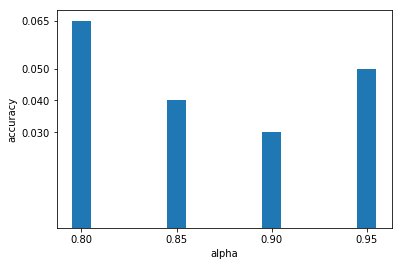

In [91]:
keys = list(info.keys())
vals = list(info.values())

plt.bar(keys,vals,align='center',width=0.01)
plt.ylabel ('accuracy')
plt.yticks(list(vals))
plt.xlabel ('alpha')
plt.xticks(list(keys))
plt.savefig('pcaAccuracy.png')
plt.show()


In [46]:
def pca():
  pca = PCA(n_components= 200)
  pca_model= pca.fit(train_x)
  new_dimensions = pca_model.transform(train_x)  
  #plt.scatter(new_dimensions[:,0],new_dimensions[:,1])  
  #print(pca.explained_variance_ratio_)  
  #print(new_dimensions.shape)
  #print(pca.explained_variance_ratio_)
  return  new_dimensions

new_dimensions= pca()


In [47]:
PCA(train_x)

PCA(copy=True, iterated_power='auto',
  n_components=array([[ 24.,  26., ..., 180., 178.],
       [ 22.,  19., ..., 158., 166.],
       ...,
       [126., 124., ...,  81.,  78.],
       [128., 123., ...,  77.,  83.]]),
  random_state=None, svd_solver='auto', tol=0.0, whiten=False)

In [48]:
#LDA

In [92]:
def pca_classification_70(transformed_70,reducedVec_70):    
    infoPCA={}
    for i in [1,3,5,7]:
        infoPCA[i]={}
        for key, vals in transformed_70.items(): 
            test_X=np.absolute(test_70_X.dot(reducedVec_70[key].T))
            score=kmodel_score(vals, train_70_y, test_X, test_70_y,i)
            infoPCA[i][key]=score 
    for i in infoPCA.keys():
        keys = list(infoPCA[i].keys())
        vals = list(infoPCA[i].values())
        plt.bar(keys,vals,align='center',width=0.01,label=i)
        plt.ylabel ('accuracy')
        plt.yticks(list(vals))
        plt.xlabel ('alpha')
        plt.xticks(list(keys))
        plt.legend(loc='upper right')
        plt.savefig('./figures/PCA/pcaAccuracy70_'+str(i)+'.png')
        plt.show()

In [94]:
def pca_classification(transformed,reducedVec):    
    infoPCA={}
    for i in [1,3,5,7]:
        infoPCA[i]={}
        for key, vals in transformed.items(): 
            test_X=np.absolute(test_x.dot(reducedVec[key].T))
            score=kmodel_score(vals, train_y, test_X, test_y,i)
            infoPCA[i][key]=score 
    for i in infoPCA.keys():
        keys = list(infoPCA[i].keys())
        vals = list(infoPCA[i].values())
        plt.bar(keys,vals,align='center',width=0.01,label=i)
        plt.ylabel ('accuracy')
        plt.yticks(list(vals))
        plt.xlabel ('alpha')
        plt.xticks(list(keys))
        plt.legend(loc='upper right')
        plt.savefig('./figures/PCA/pcaAccuracy'+str(i)+'.png')
        plt.show()

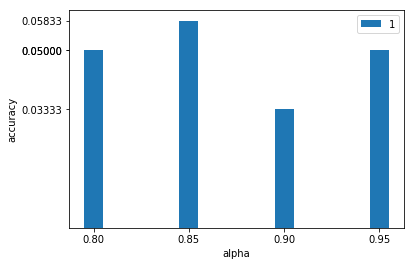

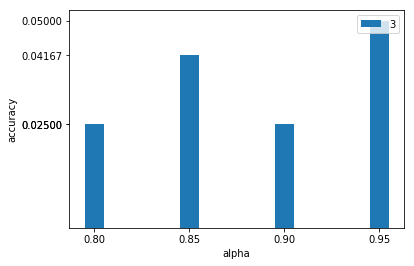

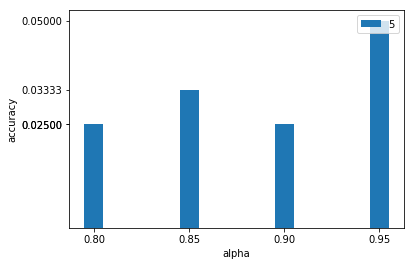

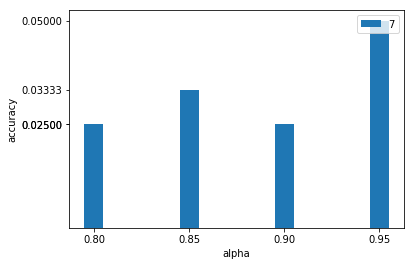

In [90]:
pca_classification_70(transformed_70,reducedVec_70)

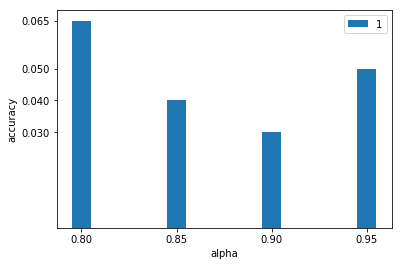

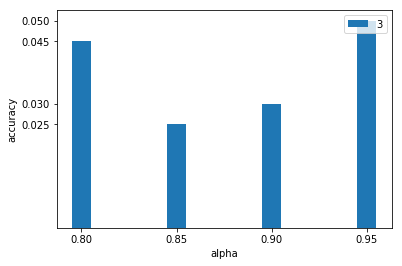

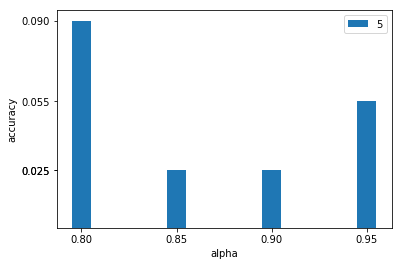

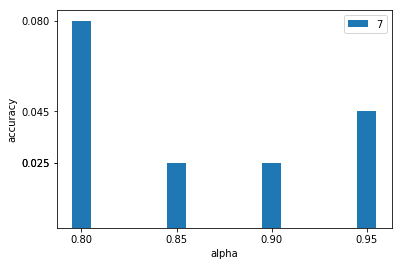

In [95]:
pca_classification(transformed,reducedVec)